In [1]:
import os
from glob import glob
import re
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
lst_filePath = glob('/mnt/d/Taiko/TJAPlayer3-Ver.1.5.2/7-ゲームミュージック/*/*.tja')

print(len(lst_filePath))
lst_filePath[:5]

142


['/mnt/d/Taiko/TJAPlayer3-Ver.1.5.2/7-ゲームミュージック/#1f1e33/#1f1e33.tja',
 '/mnt/d/Taiko/TJAPlayer3-Ver.1.5.2/7-ゲームミュージック/1116/1116.tja',
 '/mnt/d/Taiko/TJAPlayer3-Ver.1.5.2/7-ゲームミュージック/Ad astra per aspera/Ad astra per aspera.tja',
 '/mnt/d/Taiko/TJAPlayer3-Ver.1.5.2/7-ゲームミュージック/Aleph-0/Aleph-0.tja',
 '/mnt/d/Taiko/TJAPlayer3-Ver.1.5.2/7-ゲームミュージック/Altros/Altros.tja']

In [3]:
path = lst_filePath[0]

path

'/mnt/d/Taiko/TJAPlayer3-Ver.1.5.2/7-ゲームミュージック/#1f1e33/#1f1e33.tja'

In [4]:
'.tja' in path

True

In [36]:
# ファイル読み込み
with open(path, 'r', encoding='shift_jis') as f:
    lines = f.readlines()

In [37]:
# BPMと拍子の初期値を設定
current_bpm = float(re.sub('BPM:', '', [line for line in lines if re.search('BPM:', line) is not None][0]))   # ヘッダのBPM値を抽出
current_measure = float(4.0 / 4.0)

print(current_bpm, current_measure)

181.0 1.0


In [38]:
# 譜面部分を抽出
stt_line_idx = [i for i, line in enumerate(lines) if re.search('#START', line) is not None][0]
end_line_idx = [i for i, line in enumerate(lines) if re.search('#END', line) is not None][0]
scorelines = lines[stt_line_idx + 1:end_line_idx]

print(len(scorelines))
scorelines[:5]

378


['4,\n', '0,\n', '0,\n', '0000000000102100,\n', '\n']

In [39]:
def update_current_bpm(line, bpm):
    """
    BPMを更新する関数

    Parameters
    ----------
    line : str
        '#BPMCHANGE'行
    bpm : float
        現在のBPM

    Returns
    -------
    float
        更新されたBPM
    bool
        その後の処理を実行するかどうか
    """
    match = re.match('#BPMCHANGE', line)
    if match:
        return float(re.sub('#BPMCHANGE', '', line)), True
    else:
        return bpm, False

In [40]:
def update_current_measure(line, measure):
    """
    拍子を更新する関数

    Parameters
    ----------
    line : str
        '#MEASURE'行
    bpm : float
        現在の拍子

    Returns
    -------
    float
        更新された拍子
    bool
        その後の処理を実行するかどうか
    """
    match = re.match('#MEASURE', line)
    if match:
        frac = re.sub('#MEASURE', '', line).split('/')
        return float(frac[0]) / float(frac[1]), True
    else:
        return measure, False

In [41]:
def update_current_score(line):
    """
    譜面行で末尾が閉じられていない場合に，その部分を抽出する関数

    Parameters
    ----------
    line : str
        譜面行

    Returns
    -------
    str
        抽出した譜面行
    """
    match = re.match(r'[0-9]+', line)
    if match:
        return match.group()
    else:
        return ''

In [42]:
def calc_density(line, score, bpm, measure):
    """
    密度を計算する関数

    Parameters
    ----------
    line : str
        譜面行
    score : str
        その小節が複数行にまたがっていた場合のそれまでの譜面行
    bpm : float
        BPM
    measure : float
        拍子

    Returns
    -------
    list[float, float, float, float, float str]
        計算結果とその補助情報
        形式：
            ドンの密度
            カツの密度
            ドン＋カツの密度
            BPM
            拍子
            譜面
    str
        それまでストックしていた譜面行をリセットするための空文字
    bool
        その後の処理を実行するかどうか
    """
    match = re.match(r'[0-9]+,', line)
    if match:
        # ドン，カツの数をカウント
        score += match.group()
        count_don = float(score.count('1') + score.count('3'))
        count_ka = float(score.count('2') + score.count('4'))
        count_all = count_don + count_ka
        # その小節の長さ（秒数）を計算
        bar_len = 240.0 / bpm * measure
        # 密度を計算して返す
        return [count_don / bar_len, count_ka / bar_len, count_all / bar_len, bpm, measure, score], '', True
    else:
        return [0.0, 0.0, 0.0, None, None, None], score, False

In [43]:
score = ''
lst_rate = []
for line in scorelines:
    is_continue = False

    # BPM，拍子を更新
    current_bpm, is_continue = update_current_bpm(line, current_bpm)
    if is_continue:
        continue
    current_measure, is_continue = update_current_measure(line, current_measure)
    if is_continue:
        continue

    # 割合を計算
    density, score, is_continue = calc_density(line, score, current_bpm, current_measure)
    if is_continue:
        lst_rate.append(density)
        continue

    # 途中までの譜面行をストック
    score += update_current_score(line)

In [44]:
df_density = pd.DataFrame(lst_rate, columns=['don_density', 'ka_density', 'all_density', 'bpm', 'measure', 'score'])

df_density

,don_density,ka_density,all_density,bpm,measure,score
0,0.000000,0.754167,0.754167,181.0,1.0,"4,"
1,0.000000,0.000000,0.000000,181.0,1.0,"0,"
2,0.000000,0.000000,0.000000,181.0,1.0,"0,"
3,1.508333,0.754167,2.262500,181.0,1.0,"0000000000102100,"
4,0.754167,0.000000,0.754167,181.0,1.0,"3,"
...,...,...,...,...,...,...
143,6.033333,2.262500,8.295833,362.0,2.0,"1201201201101011,"
144,6.033333,0.000000,6.033333,362.0,2.0,"3003003001103011,"
145,6.033333,0.000000,6.033333,362.0,2.0,"3003003001103011,"
146,6.033333,2.262500,8.295833,362.0,2.0,"1201201201101011,"


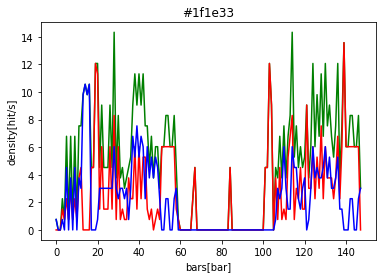

In [45]:
plt.title(re.sub('.tja', '', os.path.basename(path)))
plt.xlabel('bars[bar]')
plt.ylabel('density[hit/s]')
plt.plot(df_density.all_density, color='green')
plt.plot(df_density.don_density, color='red')
plt.plot(df_density.ka_density, color='blue')
plt.show()

In [46]:
df_density.to_csv('df_density.csv', index=False)